Jon V

April 26, 2018

# Create neural network KS model

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from KRR_reproduce import *
from generate_H2_data import *
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn import functional as fn
from torch.autograd import Variable
import pandas as pd
import scipy as sp
import sys
import time
from scipy import stats

In [36]:
# read in calculation data (computed elsewhere)
str_pref = os.environ['PROJDIR']+'/data/H2_DFT/temp_data/store/'
test = np.load(os.environ['PROJDIR']+'/data/H2_DFT/temp_data/store/sep_store/sep149.npy')

# read in the calculation data
sim_no = 150
ens = []
seps= []
fours = []

min_en = 0
eq_sep = 0

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(str_pref+'sep_store/sep'+str(n)+'.npy')
    en = np.load(str_pref+'en_store/en'+str(n)+'.npy')
    four = np.load(str_pref+'four_store/four'+str(n)+'.npy')

    # put results in a nicer format
    sep = np.reshape(sep,(1,))[0]
    en = np.reshape(en,(1,))[0]['energy']
    four = np.real(four)
    
    # get min energy and equilibrium separation
    if en < min_en:
        min_en = en
        eq_sep = sep

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

print('The minimum energy is '+str(min_en)+' eV. The equilibrium separation is '+str(eq_sep)+' Angstrom.')

The minimum energy is -31.74695245487133 eV. The equilibrium separation is 0.7483221476510067 Angstrom.


In [4]:
# define training and test sets
M = 7 # training points

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

# define train and test sets
train_set = np.array([seps[n] for n in train_indices])
test_set = np.array([seps[n] for n in test_indices])

train_ens = np.array([ens[n] for n in train_indices])
test_ens = np.array([ens[n] for n in test_indices])

train_fours = np.array([fours[n] for n in train_indices])
test_fours = np.array([fours[n] for n in test_indices])

In [5]:
# create training dataset in pytorch
H_seps = torch.Tensor(train_set)
labels = torch.Tensor(train_ens)
train_dataset = torch.utils.data.TensorDataset(H_seps,labels)

# create test set in pytorch
H_seps_test = torch.Tensor(test_set)
labels_test = torch.Tensor(test_ens)
test_dataset = torch.utils.data.TensorDataset(H_seps_test, labels_test)

In [31]:
# create network
input_dim = 1 # separation
output_dim = 1 # energy
hidden_dim = 10 # number of hidden nodes

simple_net = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.Tanh(),
#     torch.nn.Linear(hidden_dim, hidden_dim),
#     torch.nn.Tanh(),
    torch.nn.Linear(hidden_dim, output_dim),
)

# print(simple_net)

# train model
epochs = 50000
learning_rate = 0.01

model = simple_net
criterion=nn.MSELoss()
optimizer = torch.optim.SGD
optimizer = optimizer(model.parameters(),lr=learning_rate)
image_set = train_dataset

loss_array = []
iter_num = []
tot_diff = []
count = 1

model.train()

for count,epoch in enumerate(range(epochs)):
    diff_list = []
    
    for i, (images, labels) in enumerate(image_set):
        images_v = Variable(torch.Tensor(np.array([images])))
        labels_v = Variable(torch.Tensor(np.array([labels])))
        
        optimizer.zero_grad()
        outputs = model(images_v)
        loss = criterion(outputs, labels_v) 
        loss.backward()
        optimizer.step()

        loss_array.append(loss.data[0])
        iter_num.append(count)
        count+=1

    tot_diff.append(diff_list)
#     if count % 5 == 0:
#         print("Finished epoch %s" % epoch)

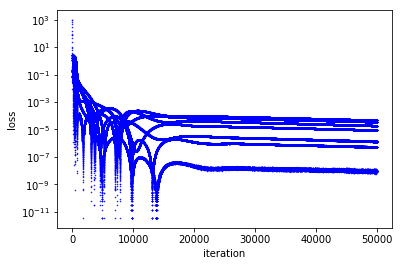

In [32]:
fig, ax = plt.subplots(1,1)
ax.plot(iter_num,loss_array,'b.', markersize = 1)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_yscale('log')

plt.show()

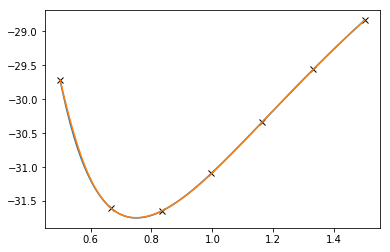

In [33]:
# plot exact values, NN model, and training points
mod_preds = []
for n in range(len(seps)):
    sep = seps[n]
    sep_var = Variable(torch.Tensor(np.array([sep])))
    mod_pred = model(sep_var).data[0]
    
    mod_preds.append(mod_pred)
    

plt.figure()
plt.plot(seps, ens)
plt.plot(train_set, train_ens, 'kx')
plt.plot(seps, mod_preds)
plt.show()

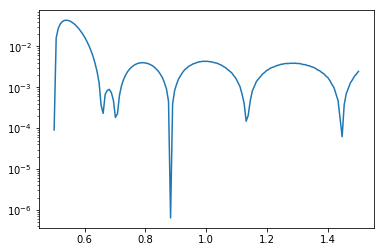

In [34]:
# plot NN error
mod_preds = []
errs = []
for n in range(len(seps)):
    sep = seps[n]
    sep_var = Variable(torch.Tensor(np.array([sep])))
    mod_pred = model(sep_var).data[0]
    
    true_val = ens[n]
    err = np.abs(true_val - mod_pred)
    
    errs.append(err)
    mod_preds.append(mod_pred)
    
fig, ax = plt.subplots(1,1)
ax.plot(seps, errs)
ax.set_yscale('log')
plt.show()

# Compare with spline interpolation

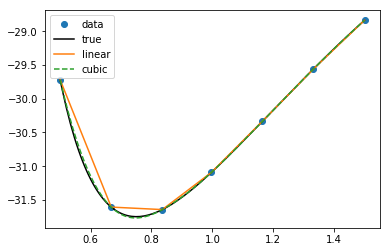

In [9]:
from scipy.interpolate import interp1d

x = train_set
y = train_ens
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = seps
spline_pred = f2(xnew)

plt.plot(x, y, 'o', seps, ens, 'k', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data','true', 'linear', 'cubic'], loc='best')
plt.show()

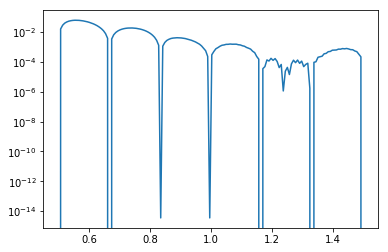

In [10]:
# plot spline error
spline_err = np.abs(spline_pred-ens)
    
fig, ax = plt.subplots(1,1)
ax.plot(seps, spline_err)
ax.set_yscale('log')
plt.show()

# Build NN model of electron density

In [6]:
# create training dataset in pytorch
H_seps = torch.Tensor(train_set)
labels = torch.Tensor(train_fours)/500
train_dataset = torch.utils.data.TensorDataset(H_seps,labels)

# create test set in pytorch
H_seps_test = torch.Tensor(test_set)
labels_test = torch.Tensor(test_fours)
test_dataset = torch.utils.data.TensorDataset(H_seps_test, labels_test)

In [7]:
# create network
input_dim = 1 # separation
output_dim = 25**3 # energy
hidden_dim = 10 # number of hidden nodes

simple_net = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.Tanh(),
#     torch.nn.Linear(hidden_dim, hidden_dim),
#     torch.nn.Tanh(),
    torch.nn.Linear(hidden_dim, output_dim),
)

# print(simple_net)

# train model
epochs = 50000
learning_rate = 0.5

model = simple_net
criterion=nn.MSELoss()
optimizer = torch.optim.SGD
optimizer = optimizer(model.parameters(),lr=learning_rate)
image_set = train_dataset

loss_array = []
iter_num = []
tot_diff = []
count = 1

model.train()

for count,epoch in enumerate(range(epochs)):
    diff_list = []
    
    for i, (images, labels) in enumerate(image_set):
        images_v = Variable(torch.Tensor(np.array([images])))
        labels_v = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images_v)
        loss = criterion(outputs, labels_v) 
        loss.backward()
        optimizer.step()

        loss_array.append(loss.data[0])
        iter_num.append(count)
        count+=1

    tot_diff.append(diff_list)
    if epoch % 1000 == 0:
        print("Finished epoch %s" % epoch)

Finished epoch 0
Finished epoch 1000
Finished epoch 2000
Finished epoch 3000
Finished epoch 4000
Finished epoch 5000
Finished epoch 6000
Finished epoch 7000
Finished epoch 8000
Finished epoch 9000
Finished epoch 10000
Finished epoch 11000
Finished epoch 12000
Finished epoch 13000
Finished epoch 14000
Finished epoch 15000
Finished epoch 16000
Finished epoch 17000
Finished epoch 18000
Finished epoch 19000
Finished epoch 20000
Finished epoch 21000
Finished epoch 22000
Finished epoch 23000
Finished epoch 24000
Finished epoch 25000
Finished epoch 26000
Finished epoch 27000
Finished epoch 28000
Finished epoch 29000
Finished epoch 30000
Finished epoch 31000
Finished epoch 32000
Finished epoch 33000
Finished epoch 34000
Finished epoch 35000
Finished epoch 36000
Finished epoch 37000
Finished epoch 38000
Finished epoch 39000
Finished epoch 40000
Finished epoch 41000
Finished epoch 42000
Finished epoch 43000
Finished epoch 44000
Finished epoch 45000
Finished epoch 46000
Finished epoch 47000
Finis

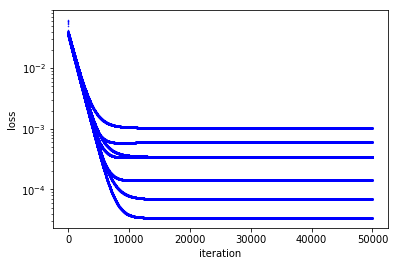

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(iter_num,loss_array,'b.', markersize = 1)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_yscale('log')

plt.show()

In [67]:
test = []
four_true = []
ind = 8
for n in range(len(seps)):
    sep = seps[n]
    sep_var = Variable(torch.Tensor(np.array([sep])))
    mod_pred = model(sep_var)
    
    test.append(float(mod_pred[ind]))
    four_true.append(fours[n][0,0,ind])
    
test = np.array(test)
four_true = np.array(four_true)

# np.array(mod_pred.data)
# plt.plot(np.array(mod_pred.data)*500,'ro',MarkerSize=1)
# plt.show()

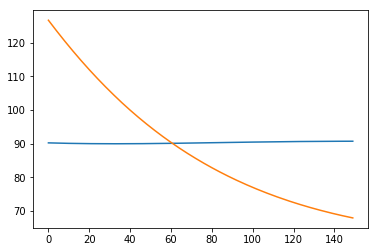

In [68]:
plt.figure()
plt.plot(test * 500)
plt.plot(four_true)
plt.show()

In [44]:
test*500

[0.9761730432510376,
 0.976197361946106,
 0.9762205481529236,
 0.9762426018714905,
 0.9762635827064514,
 0.9762834310531616,
 0.9763022661209106,
 0.9763200283050537,
 0.9763367772102356,
 0.9763525128364563,
 0.9763672947883606,
 0.9763810634613037,
 0.9763939380645752,
 0.9764058589935303,
 0.9764169454574585,
 0.9764270782470703,
 0.9764363765716553,
 0.9764447808265686,
 0.9764524698257446,
 0.976459264755249,
 0.9764653444290161,
 0.9764706492424011,
 0.976475179195404,
 0.9764790534973145,
 0.9764822125434875,
 0.9764847159385681,
 0.9764865040779114,
 0.9764876961708069,
 0.9764882922172546,
 0.9764882922172546,
 0.9764877557754517,
 0.9764865636825562,
 0.9764849543571472,
 0.9764827489852905,
 0.9764800667762756,
 0.9764769673347473,
 0.9764733910560608,
 0.9764693975448608,
 0.9764649868011475,
 0.9764601588249207,
 0.97645503282547,
 0.9764494895935059,
 0.9764436483383179,
 0.9764374494552612,
 0.9764310717582703,
 0.9764243364334106,
 0.9764173626899719,
 0.976410150527954

In [25]:
np.array(mod_pred.data)[0:25]

array([ 0.9762426 , -0.93550116,  0.82437915, -0.6827807 ,  0.53970575,
       -0.41789278,  0.31842244, -0.23647965,  0.18036442, -0.13999379,
        0.10342647, -0.0776047 ,  0.06450745, -0.04995742,  0.03872187,
       -0.02916812,  0.02542224, -0.02157416,  0.01806566, -0.0122445 ,
        0.0100156 , -0.01087287,  0.00797699, -0.00675638,  0.00549716],
      dtype=float32)

In [21]:
fours[1][0,0,0:25]/500

array([ 0.97656395, -0.945782  ,  0.86233237, -0.74738193,  0.62333308,
       -0.5062196 ,  0.40422286, -0.31968846,  0.2517134 , -0.19802703,
        0.1560492 , -0.12338253,  0.09799098, -0.07822677,  0.06279334,
       -0.0506877 ,  0.04114152, -0.03356912,  0.02752477, -0.022669  ,
        0.01874271, -0.0155475 ,  0.01293093, -0.01077538,  0.00898976])

In [ ]:
# plot NN error
mod_preds = []
errs = []
for n in range(len(seps)):
    sep = seps[n]
    sep_var = Variable(torch.Tensor(np.array([sep])))
    mod_pred = model(sep_var).data[0]
    
    true_val = ens[n]
    err = np.abs(true_val - mod_pred)
    
    errs.append(err)
    mod_preds.append(mod_pred)
    
fig, ax = plt.subplots(1,1)
ax.plot(seps, errs)
ax.set_yscale('log')
plt.show()

# Build density to energy NN model

In [16]:
# define training and test sets
M = 7 # training points

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

# define train and test sets
train_set = np.array([seps[n] for n in train_indices])
test_set = np.array([seps[n] for n in test_indices])

train_ens = np.array([ens[n] for n in train_indices])/40
test_ens = np.array([ens[n] for n in test_indices])

train_fours = np.array([fours[n] for n in train_indices])/500
test_fours = np.array([fours[n] for n in test_indices])

In [17]:
# create training dataset in pytorch
H_seps = torch.Tensor(train_fours)
labels = torch.Tensor(train_ens)
train_dataset = torch.utils.data.TensorDataset(H_seps,labels)

# create test set in pytorch
H_seps_test = torch.Tensor(test_fours)
labels_test = torch.Tensor(test_ens)
test_dataset = torch.utils.data.TensorDataset(H_seps_test, labels_test)

In [22]:
# create network
input_dim = 25**3 # fourier components
output_dim = 1 # energy
hidden_dim = 5 # number of hidden nodes

simple_net = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_dim, hidden_dim),
    torch.nn.Tanh(),
#     torch.nn.Linear(hidden_dim, hidden_dim),
#     torch.nn.Sigmoid(),
#     torch.nn.Linear(hidden_dim, hidden_dim),
#     torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_dim, output_dim),
)

# print(simple_net)

# train model
epochs = 50000
learning_rate = 0.1

model = simple_net
criterion=nn.MSELoss()
optimizer = torch.optim.SGD
optimizer = optimizer(model.parameters(),lr=learning_rate)
image_set = train_dataset

loss_array = []
iter_num = []
tot_diff = []
count = 1

model.train()

for count,epoch in enumerate(range(epochs)):
    diff_list = []
    
    for i, (images, labels) in enumerate(image_set):
        images_v = Variable(images.view(-1,input_dim))
        labels_v = Variable(torch.Tensor(np.array([labels])))
        
        optimizer.zero_grad()
        outputs = model(images_v)
        loss = criterion(outputs, labels_v) 
        loss.backward()
        optimizer.step()

        loss_array.append(loss.data[0])
        iter_num.append(count)
        count+=1

    tot_diff.append(diff_list)
    if epoch % 1000 == 0:
        print("Finished epoch %s" % epoch)

Finished epoch 0
Finished epoch 1000
Finished epoch 2000
Finished epoch 3000
Finished epoch 4000
Finished epoch 5000
Finished epoch 6000
Finished epoch 7000
Finished epoch 8000
Finished epoch 9000
Finished epoch 10000
Finished epoch 11000
Finished epoch 12000
Finished epoch 13000
Finished epoch 14000
Finished epoch 15000
Finished epoch 16000
Finished epoch 17000
Finished epoch 18000
Finished epoch 19000
Finished epoch 20000
Finished epoch 21000
Finished epoch 22000
Finished epoch 23000
Finished epoch 24000
Finished epoch 25000
Finished epoch 26000
Finished epoch 27000
Finished epoch 28000
Finished epoch 29000
Finished epoch 30000
Finished epoch 31000
Finished epoch 32000
Finished epoch 33000
Finished epoch 34000
Finished epoch 35000
Finished epoch 36000
Finished epoch 37000
Finished epoch 38000
Finished epoch 39000
Finished epoch 40000
Finished epoch 41000
Finished epoch 42000
Finished epoch 43000
Finished epoch 44000
Finished epoch 45000
Finished epoch 46000
Finished epoch 47000
Finis

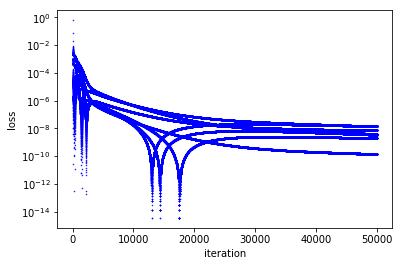

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(iter_num,loss_array,'b.', markersize = 1)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_yscale('log')

plt.show()

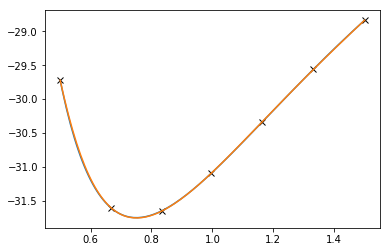

In [24]:
# plot exact values, NN model, and training points
mod_preds = []
for n in range(len(fours)):
    four = fours[n]/500
    im = torch.Tensor(four)
    im = im.contiguous()
    sep_var = Variable(im.view(-1,25**3))
#     print(sep_var)
    mod_pred = float(model(sep_var))
    
    mod_preds.append(mod_pred)
    
mod_preds = np.array(mod_preds)

plt.figure()
plt.plot(seps, ens)
plt.plot(train_set, train_ens*40, 'kx')
plt.plot(seps, mod_preds*40)
plt.show()

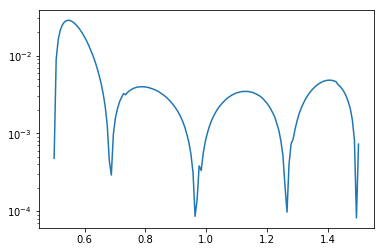

In [25]:
# plot NN error
mod_preds = []
errs = []
for n in range(len(seps)):
    four = fours[n]/500
    im = torch.Tensor(four)
    im = im.contiguous()
    sep_var = Variable(im.view(-1,25**3))
#     print(sep_var)
    mod_pred = float(model(sep_var))*40
    
    true_val = ens[n]
    err = np.abs(true_val - mod_pred)
    
    errs.append(err)
    mod_preds.append(mod_pred)
    
fig, ax = plt.subplots(1,1)
ax.plot(seps, errs)
ax.set_yscale('log')
plt.show()

In [28]:
mean_err = np.mean(errs)
mean_err

0.004882596569702808

In [29]:
# calculate mean error in kcal
kcal_conv = 0.043
mean_err / kcal_conv

0.11354875743494904

In [30]:
max_err = np.max(errs)

In [32]:
max_err / kcal_conv

0.6601853374360719